# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);


1.6.0 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold  
  probas_to_keep = probas[keep]


  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [4]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
%cd ../..
%ls

/home/daniel/Work/detr
cab/                           hubconf.py*        run_output_old/
d2/                            LICENSE*           runs/
datasets/                      main.py*           run_with_submitit.py*
detr-r101_panoptic.pth         masks1.pt          test_all.py*
detr-r50_no-class-head.pth     masks2.pt          test_mask176.pt
detr-r50_panoptic_no-head.pth  models/            test_mask57.pt
detr-r50_panoptic.pth          __pycache__/       tox.ini*
detr-r50.pth                   README.md*         util/
Dockerfile*                    requirements.txt*
engine.py*                     run_output/


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

# Only run one of these!!!

In [54]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
#del checkpoint['model']['query_embed.weight']
#del checkpoint['model']['query_embed.bias']

# Save
torch.save(checkpoint,'detr-r50_panoptic_no-head.pth')

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [63]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0


assert(first_class_index in [0, 1])

if first_class_index == 0:

  num_classes = 12

  finetuned_classes = [
      'front_door',
      'rear_door',
      'front_fender',
      'rear_panel',
      'sill', 
      'rearview_mirror', 
      'front_bumper', 
      'left_front_headlight', 
      'hood', 
      'rear_bumper', 
      'wheels',
      'not_door',
  ]

else:
  num_classes = 4
  finetuned_classes = [
      'NA/',
      'front_door',
      'rear_door',
      'not_door',
      ]


print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

# num_classes > class_id.max()

First class index: 0
Parameter num_classes: 12
Fine-tuned classes: [&#39;front_door&#39;, &#39;rear_door&#39;, &#39;front_fender&#39;, &#39;rear_panel&#39;, &#39;sill&#39;, &#39;rearview_mirror&#39;, &#39;front_bumper&#39;, &#39;left_front_headlight&#39;, &#39;hood&#39;, &#39;rear_bumper&#39;, &#39;wheels&#39;, &#39;not_door&#39;]


In [66]:
# When training both OD and SEGM in one run, launch the following 3 windows to train both the od and segm head.
# Make sure to reaname od_run_name and segm_run_name appropriately
import os
from datetime import datetime

now = datetime.now()
od_run_name = "OD body (T:hdrp3, V:Z) P:r50"
time = now.strftime("%Y_%m_%d-%H:%M")
od_dir = time  + " " + od_run_name
od_dir_name = "'run_output_old/" + time  + " " + od_run_name + "'"
od_tb_name = "'" + time  + " " + od_run_name + "'"
od_pth_name = "'run_output_old/" + time + " " + od_run_name + "/best.pth'"


segm_run_name = "SEGM body (T:hdrp3, V:Z) P:" + time
segm_dir = time  + " " + segm_run_name
segm_dir_name = "'run_output_old/" + time  + " " + segm_run_name + "'"
segm_tb_name = "'" + time  + " " + segm_run_name + "'"

os.mkdir('run_output_old/' + od_dir)
os.mkdir('run_output_old/' + segm_dir)

In [73]:
!python main.py \
  --tb_name $od_tb_name \
  --dataset_file "coco_panoptic" \
  --coco_path "/mnt/data2/datasets/detr/detr_body (T:hdrp3, V:hdrp3)/" \
  --coco_panoptic_path '/mnt/data2/datasets/detr/detr_body_panoptic (T:hdrp3, V:hdrp3)/' \
  --resume 'detr-r50_panoptic_no-head.pth' \
  --output_dir $od_dir_name \
  --num_classes $num_classes \
  --epochs 80 \
  --lr_drop 65


Not using distributed mode
git:
  sha: 6fdb254162532c8178d47eb1b65f5b0e19e19ef8, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone=&#39;resnet50&#39;, batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=&#39;/mnt/data2/datasets/detr/detr_body_panoptic (T:hdrp3, V:hdrp3)/&#39;, coco_path=&#39;/mnt/data2/datasets/detr/detr_body (T:hdrp3, V:hdrp3)/&#39;, dataset_file=&#39;coco_panoptic&#39;, dec_layers=6, device=&#39;cuda&#39;, dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url=&#39;env://&#39;, distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=80, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=65, mask_loss_coef=1, masks=False, nheads=8, num_classes=12, num_queries=100, num_workers=2, output_dir=&#39;run_output_old/2020_10_08-17:00 OD body (T:hdrp3, V:Z) P:r50&#39;, position_embedding=&#39;sine&#39;, pre_norm=False, remove_difficult=False, resume=&#39

In [68]:
!python main.py \
  --tb_name $segm_tb_name \
  --dataset_file "coco_panoptic" \
  --coco_path "/mnt/data2/datasets/detr/detr_body (T:hdrp3, V:hdrp3)/" \
  --coco_panoptic_path '/mnt/data2/datasets/detr/detr_body_panoptic (T:hdrp3, V:hdrp3)/' \
  --frozen_weights $od_pth_name \
  --output_dir $segm_dir_name \
  --num_classes $num_classes \
  --epochs 5000 \
  --lr_drop 500 \
  --masks \
  --batch_size 1


  

Not using distributed mode
git:
  sha: 6fdb254162532c8178d47eb1b65f5b0e19e19ef8, status: has uncommited changes, branch: master

Namespace(aux_loss=True, backbone=&#39;resnet50&#39;, batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=&#39;/mnt/data2/datasets/detr/detr_body_panoptic (T:hdrp3, V:Z)/&#39;, coco_path=&#39;/mnt/data2/datasets/detr/detr_body (T:hdrp3, V:Z)/&#39;, dataset_file=&#39;coco_panoptic&#39;, dec_layers=6, device=&#39;cuda&#39;, dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url=&#39;env://&#39;, distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=5000, eval=False, frozen_weights=&#39;run_output_old/2020_10_08-17:00 OD body (T:hdrp3, V:Z) P:r50/best.pth&#39;, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=500, mask_loss_coef=1, masks=True, nheads=8, num_classes=12, num_queries=100, num_workers=2, output_dir=&#39;run_output_old/2020_10_08-17:00 SEGM body (T:hdrp3, V:Z) P:2020_10_08-17:00&#39;, po

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [39]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('run_output')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

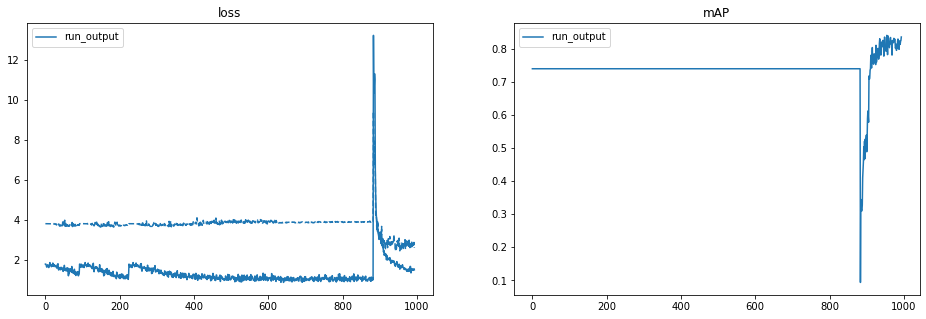

In [40]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

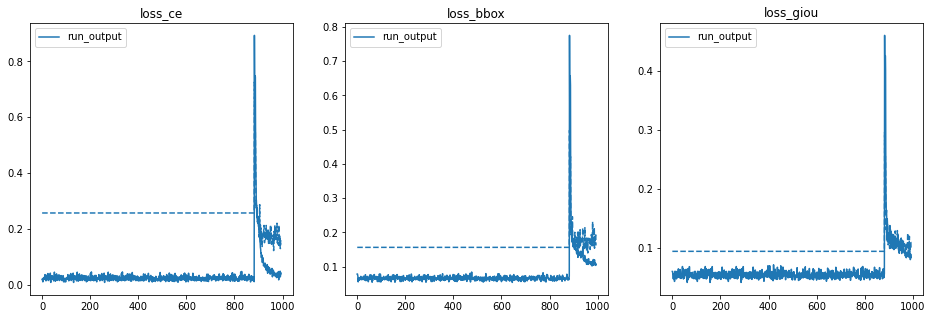

In [41]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

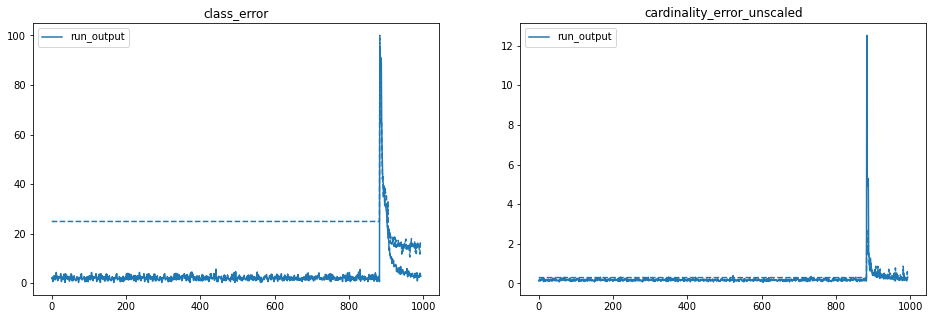

In [42]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [43]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('run_output/checkpoint.pth', map_location='cpu')

model.load_state_dict(checkpoint['model'], strict=False)

model.eval();

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_detr_master


### Boilerplate functions to display fine-tuned results

In [51]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [52]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,0.5)


  plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


  #for threshold in [0.9, 0.7]:
    
  #  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
  #                                                            threshold=threshold)

  #  print(probas_to_keep)

   # plot_finetuned_results(my_image,
                          #  probas_to_keep, 
                          #  bboxes_scaled)


### With a training image

In [54]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

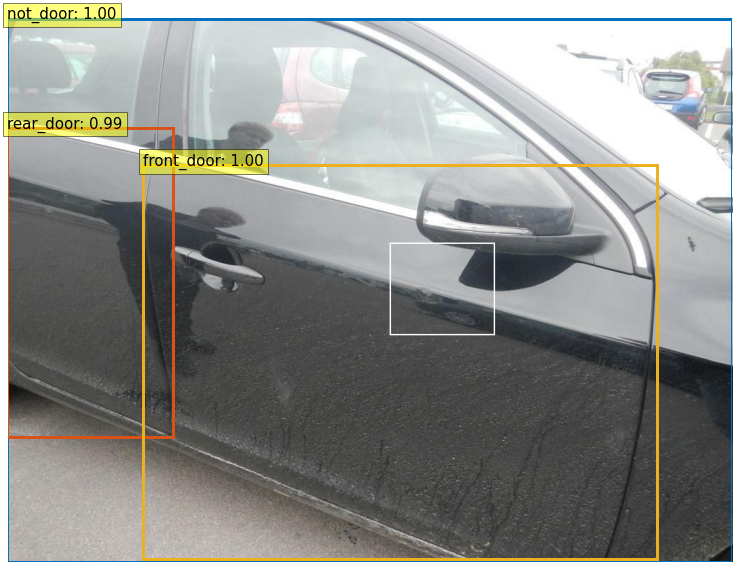

In [61]:
from PIL import Image

img_name = '/mnt/data2/datasets/detr/detr_doors (T:D, V:Z)/val2017/006.jpg'
im = Image.open(img_name)

run_worflow(im, model)

### With a validation image

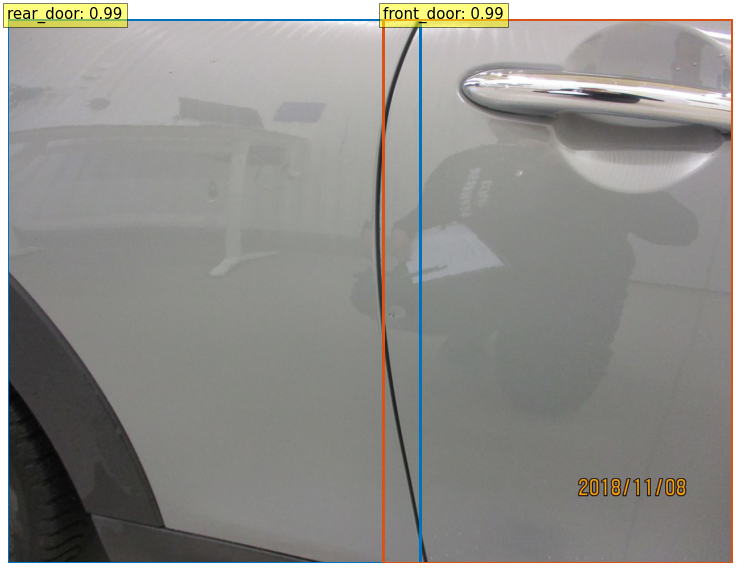

In [256]:
from PIL import Image

img_name = '/mnt/data2/datasets/detr_doors_coco_structure_100_images/val2017/026.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)